### 1) Dataset Sizes
Find out the size of general and scientific datasets. Ideally this includes a storage need estimate
in GB, the shape of this data (e.g. language, images, video, time-series data) with the respective
dimensions. Generate a plot of the respective storage needs which shows the respective scales.

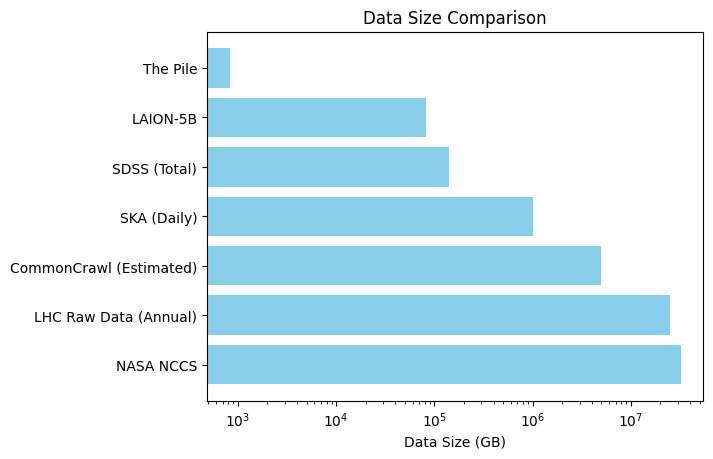

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
dataDict = {
    'NASA NCCS': 32000000,
    'LHC Raw Data (Annual)': 25000000,
    'CommonCrawl (Estimated)': 5000000,
    'SKA (Daily)': 1000000,
    'SDSS (Total)': 140000,
    'LAION-5B': 82000,
    'The Pile': 825
}

plt.barh(list(dataDict.keys()), list(dataDict.values()), color='skyblue')
plt.xlabel('Data Size (GB)')
plt.title('Data Size Comparison')
plt.xscale('log')
plt.show()


## 2 Bias vs variance trade-off
In the lectures we have discussed two schematic plots:
• Number of data points vs. Error.
• Model complexity vs. Error.
Based on the example in the lectures, perform an experiment with polynomials which shows
this behaviour. Remember this is the expected result out of many realisations

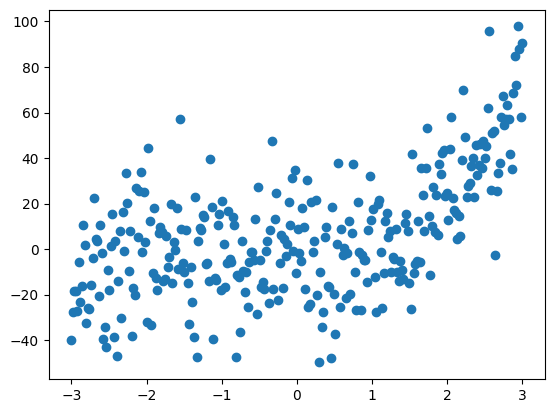

In [62]:
# create some synthetic data
N_train = 300
sigma = 20
x = np.linspace(-3, 3, N_train)
# N_train normally distributed samples
noise = np.random.randn(N_train) * sigma

def theoreticalModel(x):
    return 2 * x**3 + 3 * x**2 - 2 * x - 3

y = theoreticalModel(x) + noise

plt.plot(x, y, "o")

0.4663485672082528


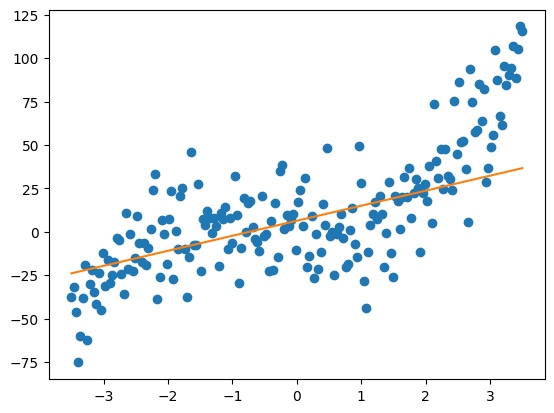

In [66]:
# linear model
fitted = linear_model.LinearRegression().fit(x[:, np.newaxis], y)

# generate some new test data
N_test = 200
noise_test = np.random.randn(N_test) * 20
x_test = np.linspace(-3.5, 3.5, N_test)
y_test = theoreticalModel(x_test) + noise_test

# check R^2 score, v bad as you expect
stats = fitted.score(x_test[:, np.newaxis], y_test)
print(stats)
plt.plot(x_test, y_test, "o")
plt.plot(x_test, fitted.predict(x_test[:, np.newaxis]))



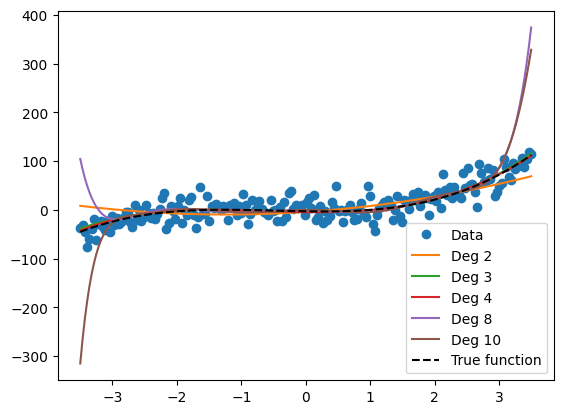

0.530170095001164
0.7301887896175235
0.7341735571107753
-0.5447243604000906
-0.8027100048456703


In [70]:
p2 = PolynomialFeatures(degree = 2)
p3 = PolynomialFeatures(degree = 3)
p4 = PolynomialFeatures(degree = 4)
p8 = PolynomialFeatures(degree = 8)
p10 = PolynomialFeatures(degree = 10)

x2 = p2.fit_transform(x[:, np.newaxis])
x3 = p3.fit_transform(x[:, np.newaxis])
x4 = p4.fit_transform(x[:, np.newaxis])
x8 = p8.fit_transform(x[:, np.newaxis])
x10 = p10.fit_transform(x[:, np.newaxis])

pm2 = linear_model.LinearRegression()
pm2.fit(x2, y)

pm3 = linear_model.LinearRegression()
pm3.fit(x3, y)

pm4 = linear_model.LinearRegression()
pm4.fit(x4, y)

pm8 = linear_model.LinearRegression()
pm8.fit(x8, y)

pm10 = linear_model.LinearRegression()
pm10.fit(x10, y)

plt.plot(x_test, y_test, "o")
plt.plot(
    x_test,
    pm2.predict(
        p2.fit_transform(x_test[:, np.newaxis])
        )
    )
plt.plot(
    x_test,
    pm3.predict(
        p3.fit_transform(x_test[:, np.newaxis])
    )
)
plt.plot(
    x_test,
    pm4.predict(
        p4.fit_transform(x_test[:, np.newaxis])
    )
)
plt.plot(
    x_test,
    pm8.predict(
        p8.fit_transform(x_test[:, np.newaxis])
    )
)
plt.plot(
    x_test,
    pm10.predict(
        p10.fit_transform(x_test[:, np.newaxis])
    )
)
plt.plot(x_test, theoreticalModel(x_test), "k--", label="True function")
plt.legend(["Data", "Deg 2", "Deg 3", "Deg 4", "Deg 8", "Deg 10", "True function"])
plt.show()

print(pm2.score(p2.fit_transform(x_test[:, np.newaxis]), y_test))
print(pm3.score(p3.fit_transform(x_test[:, np.newaxis]), y_test))
print(pm4.score(p4.fit_transform(x_test[:, np.newaxis]), y_test))
print(pm8.score(p8.fit_transform(x_test[:, np.newaxis]), y_test))
print(pm10.score(p10.fit_transform(x_test[:, np.newaxis]), y_test))




## 3 Gradient descent – Adam

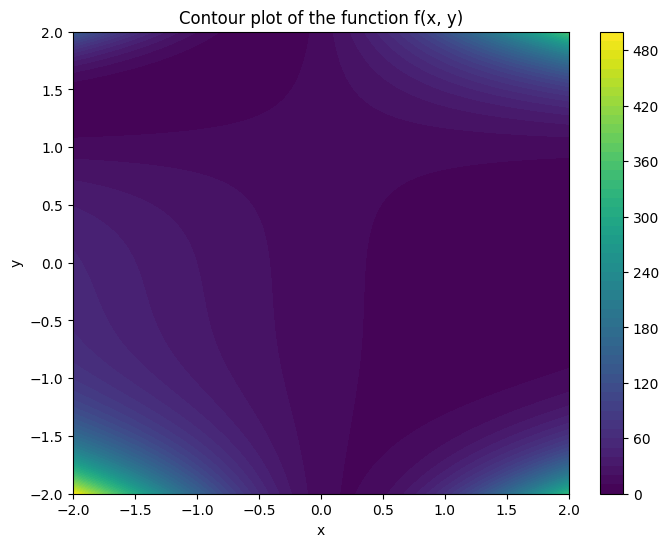

In [76]:
def f(x, y):
  """
  Calculates the value of the function f(x, y) from the exercise.
  """
  term1 = (1.5 - x + x * y)**2
  term2 = (2.25 - x + x * y**2)**2
  term3 = (2.625 - x + x * y**3)**2
  return term1 + term2 + term3

plt.figure(figsize=(8, 6))
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
cp = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.title('Contour plot of the function f(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [168]:
# calculate gradients to find g_t
df_dx = lambda x, y: 2 * (1.5 - x + x * y) * (-1 + y) + \
                   2 * (2.25 - x + x * y**2) * (-1 + y**2) + \
                   2 * (2.625 - x + x * y**3) * (-1 + y**3)
df_dy = lambda x, y: 2 * (1.5 - x + x * y) * (x) + \
                   4 * (2.25 - x + x * y**2) * (x * y) + \
                   6 * (2.625 - x + x * y**3) * (x * y**2)


gamma = .9
beta1 = beta2 = .99
eps = 10e-8
eta = 10e-3
N_steps = 1000


In [169]:
from numpy.typing import NDArray
FloatArray  = NDArray[np.float64]
def adam_step(
        t: int,
        theta_t: FloatArray,
        mt_minus_1: FloatArray = np.zeros(2),
        st_minus_1: FloatArray = np.zeros(2)
    ) -> tuple[FloatArray, FloatArray, FloatArray]:
    g_t = np.array([df_dx(theta_t[0], theta_t[1]), df_dy(theta_t[0], theta_t[1])])
    m_t = beta1 * mt_minus_1 + (1 - beta1) * g_t
    s_t = beta2 * st_minus_1 + (1 - beta2) * (g_t**2)
    mhat_t = m_t / (1 - beta1**t)
    shat_t = s_t / (1 - beta2**t)
    theta_t_plus_1 = theta_t - (eta * mhat_t) / (np.sqrt(shat_t) + eps)
    return theta_t_plus_1, m_t, s_t

In [ ]:
def calculate_adam_path(theta_0: FloatArray):
    # initial state
    adam_steps = theta_0.reshape(1, -1)  # Initialize as 2D array with shape (1, 2)
    print(f"Initial adam_steps shape: {adam_steps.shape}")
    print(f"Initial adam_steps:\n{adam_steps}")

    # x = np.append(adam_steps, np.array([2.,2.]).reshape(1,-1), axis = 0)
    # print(x)
    print(adam_steps[-1])

    mom = None
    var = None
    for i in range(1, N_steps + 1):
        if i == 1:
            new_step, mom, var = adam_step(i, adam_steps[-1])
            adam_steps = np.vstack([adam_steps, new_step])
        else:
            new_step, mom, var = adam_step(
                i,
                adam_steps[-1],
                mom,
                var
            )
            adam_steps = np.vstack([adam_steps,new_step])
    return adam_steps

adam_1 = calculate_adam_path(np.array([-1.5, -1.5]))
adam_2 = calculate_adam_path(np.array([5, -1.5]))

Initial adam_steps shape: (1, 2)
Initial adam_steps:
[[-1.5 -1.5]]
[-1.5 -1.5]
Initial adam_steps shape: (1, 2)
Initial adam_steps:
[[ 5.  -1.5]]
[ 5.  -1.5]


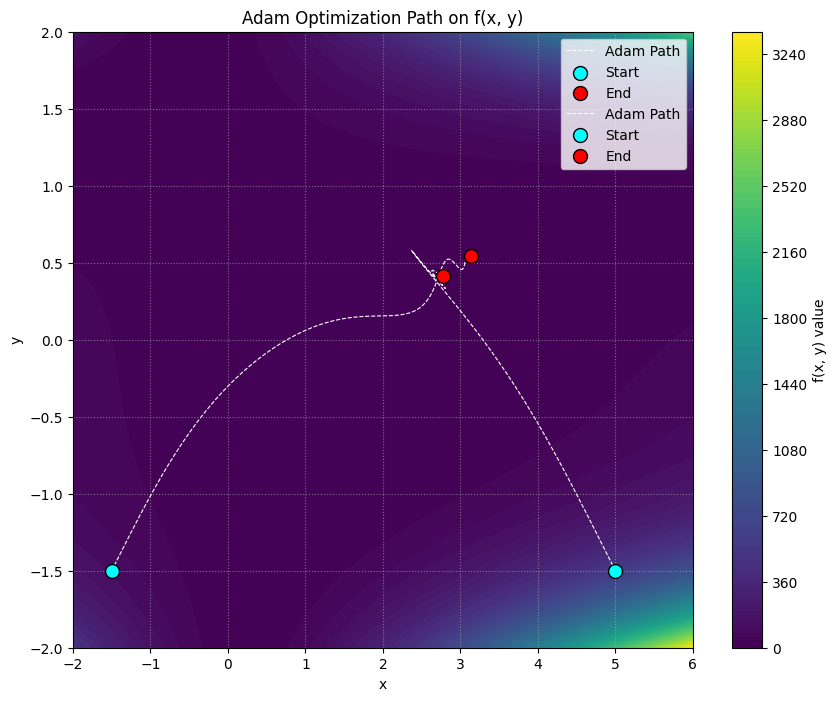

In [171]:
# 1. Setup the figure and axes object
fig, ax = plt.subplots(figsize=(10, 8))

# 2. Create data for the contour plot within the relevant range
# --- FIX: Reverted range from (-3, 3) back to (-2, 2) ---
x = np.linspace(-2, 6, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# 3. Plot the contour plot on the axes
# --- FIX: Using a higher number of linear levels instead of logspace ---
cp = ax.contourf(X, Y, Z, levels=100, cmap='viridis')
fig.colorbar(cp, ax=ax, label='f(x, y) value')

# 4. Plot the Adam optimizer path (this part was correct)
x_steps1 = adam_1[:, 0]
y_steps1 = adam_1[:, 1]
ax.plot(x_steps1, y_steps1,
        color='white', marker=None,
        linestyle='--', linewidth=.8, label='Adam Path')

# 5. Highlight the start and end points
ax.scatter(x_steps1[0], y_steps1[0], color='cyan', s=100, zorder=5, edgecolors='black', label='Start')
ax.scatter(x_steps1[-1], y_steps1[-1], color='red', s=100, zorder=5, edgecolors='black', label='End')

# 4. Plot the Adam optimizer path (this part was correct)
x_steps2 = adam_2[:, 0]
y_steps2 = adam_2[:, 1]
ax.plot(x_steps2, y_steps2,
        color='white', marker=None,
        linestyle='--', linewidth=.8, label='Adam Path')

# 5. Highlight the start and end points
ax.scatter(x_steps2[0], y_steps2[0], color='cyan', s=100, zorder=5, edgecolors='black', label='Start')
ax.scatter(x_steps2[-1], y_steps2[-1], color='red', s=100, zorder=5, edgecolors='black', label='End')

# 6. Set titles and labels
ax.set_title('Adam Optimization Path on f(x, y)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim([-2, 6]) # Ensure axes limits match the data range
ax.set_ylim([-2, 2])
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)

# 7. Display the plot
plt.show()

Above results show that the start position of the the optimiser affects the speed of optimisation. If N is increased to 2000, they more closely converge.

## 4) Fun in high dimensions